In [12]:
import math
import abc
import joblib
import numpy as np
import scipy.linalg as la

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    ConstantKernel,
    RBF,
    WhiteKernel,
)
class _BaseGP(abc.ABC):
    """Base class for Gaussian process regressor wrappers."""

    def __init__(self, kernel, n_restarts_optimizer, alpha=0):
        """Initialize the underlying Gaussian process regressor."""
        self.gpr = GaussianProcessRegressor(
            kernel=kernel,
            n_restarts_optimizer=n_restarts_optimizer,
            alpha=alpha,
        )

    # Properties --------------------------------------------------------------
    @property
    def gpr(self):
        """Underlying scikit-learn GaussianProcessRegressor."""
        return self.__gpr

    @gpr.setter
    def gpr(self, gp):
        """Ensure that the gpr a scikit-learn GaussianProcessRegressor."""
        if not isinstance(gp, GaussianProcessRegressor):
            raise TypeError("expected GaussianProcessRegressor object")
        self.__gpr = gp

    @property
    def nsamples(self):
        """Number of samples used to train the GP."""
        if hasattr(self, "train_indices"):
            return self.t_training.size

    # Main routines -----------------------------------------------------------
    def fit(self, t_training, training_data):
        """Fit the (1D) Gaussian process to compressed snapshot data.

        Parameters
        ----------
        t_snapshots : (nsamples,) ndarray
            Time domain corresponding to the available training snapshots.
        training_data : (nsamples,) ndarray
            Available training snapshots for a single state variable.
        """
        if training_data.ndim > 1:
            raise ValueError("GP training data must be one-dimensional")

        # Fit the Gaussian process to the data.
        self.t_training = t_training
        self.y = training_data
        self.gpr.fit(t_training[:, None], self.y)

        return self

    def predict(self, t):
        """Predict with the trained Gaussian process.

        Parameters
        ----------
        t : (m,) ndarray
            Times at which to evaluate the GP.

        Returns
        -------
        mean : (m,) ndarray
            Mean GP prediction at each point.
        std : (m,) ndarray
            Standard deviation of the GP prediction at each point.
        """
        return self.gpr.predict(t[:, None], return_std=True)

    def prediction_bounds(self, t, kind="95%"):
        """Get prediction bounds.

        Parameters
        ----------
        t : (m,) ndarray
            Times at which to evaluate the GP.
        kind : str
            Type of prediction band to produce.
            * "std": One standard deviation, mean ± std.
            * "95%": 95% confidence interval, mean ± 1.96*std.
            * "2std": Two standard deviations, mean ± 2*std.
            * "3std": Three standard deviations, mean ± 3*std.

        Returns
        -------
        lower : (m,) ndarray
            Lower bound of the GP prediction at each point.
        mean : (m,) ndarray
            Mean GP prediction at each point.
        upper : (m,) ndarray
            Upper bound of the GP prediction at each point.
        """
        mean, std = self.predict(t)

        if kind == "std":
            width = std
        elif kind == "95%":
            width = 1.96 * std
        elif kind == "2std":
            width = 2 * std
        elif kind == "3std":
            width = 3 * std
        else:
            raise ValueError(kind)

        return mean - width, mean, mean + width

    def __call__(self, t, tprime):
        """Evaluate the kernel.

        Parameters
        ----------
        t : (m,) ndarray
            First set of times at which to evaluate the GP.
        tprime : (mprime,) ndarray
            Second set of times at which to evaluate the GP.

        Returns
        -------
        kernel(t, tprime) : (m, mprime) ndarray
            Kernel evaluation.
        """
        return self.gpr.kernel_(t[:, None], tprime[:, None])

    # Persistence -------------------------------------------------------------
    def save(self, save_path):
        """Save the GP regressor to a file with joblib."""
        joblib.dump(self, save_path)

    @staticmethod
    def load(load_path):
        """Load a GP regressor with joblib."""
        return joblib.load(load_path)

    # Abstract methods --------------------------------------------------------
    @abc.abstractmethod
    def compute_lstsq_matrices(self, t_est, **kwargs):
        r"""Compute data needed for the GP-BayesOpInf least squares.

        Parameters
        ----------
        t_est : (trainsize,) ndarray
            Time domain at which to estimate states and time derivatives
            for the parameter estimation.
        """
        raise NotImplementedError

    def _compute_estimates_and_weights(
        self,
        K_yy: np.ndarray,
        K_zy: np.ndarray,
        K_zz: np.ndarray,
        kappa_zy: np.ndarray,
        eta: float = 1e-8,
    ):
        """Compute state and time derivative estimates from kernel matrices.

        Parameters
        ----------
        K_yy : (m, m) ndarray
            kappa(t, t) + noise * I
        K_zy : (m', m) ndarray
            d/d1 kappa(t', t)
        K_zz : (m', m') ndarray
            d^2/d1d2 kappa(t', t')
        kappa_zy : (m', m) ndarray
            Kernel evaluated at the estimation times and the training times.
        eta : float >= 0
            Regularization constant for the computation of the weight matrix.

        Returns
        -------
        Nothing, but the following attributes are set:
        * state_estimate : (m',) ndarray
            Mean estimates for the state at the estimation times.
        * ddt_estimate : (m',) ndarray
            Mean estimates for the time derivatives at the estimation times.
        * ddt_covariance : (m', m') ndarray
            Covariance for the time derivatives at the estimation times.
        * sqrtW : (m', m') ndarray
            Approximate square root of the weight matrix W_zz.
        """
        # Cholesky factor K_yy since we need the action of inv(K_yy).
        K_yy = la.cho_factor(K_yy, overwrite_a=True, check_finite=True)

        # Compute the approximate state over the full time domain.
        K_yy_inv_y = la.cho_solve(K_yy, self.y)
        self.state_estimate = kappa_zy @ K_yy_inv_y

        # Compute the approximate time derivative over the full time domain.
        self.ddt_estimate = K_zy @ K_yy_inv_y

        # Calculate covariance C = inv(W_zz) and stabilize for inversion.
        _Kzyyyyz = K_zy @ la.cho_solve(K_yy, K_zy.T)
        _Kzyyyyz = 0.5 * (_Kzyyyyz + _Kzyyyyz.T)  # Symmetrize.
        self.ddt_covariance = C = K_zz - _Kzyyyyz

        # Compute the sqrt(inv(C)) via truncated eigendecomposition.
        C_evals, C_evecs = la.eigh(
            C + (eta * np.eye(K_zz.shape[0])),
            check_finite=False,
        )
        if np.any(C_evals <= 0):
            raise ValueError(
                "inverse covariance not positive definite, increase eta"
            )
        self.sqrtW = C_evecs @ np.diag(1 / np.sqrt(C_evals)) @ C_evecs.T


class GP_RBFW(_BaseGP):
    """Gaussian process regressor with the following kernel:

    k(t, t') = constant * (RBF(t, t'; length_scale) + noise_level δ(|t - t'|)).

    This class lightly wraps sklearn.gaussian_process.GaussianProcessRegressor.

    Attributes
    ----------
    gpr : sklearn.gaussian_process.GaussianProcessRegressor
    constant : float >= 0
    length_scale : float >= 0
    noise_level : float >= 0
    train_indices : (m',) ndarray
        Subset of full time domain used to fit GP, i.e., t' = t[train_indices].
    y : (m',) ndarray
        Training data for selecting GP hyperparameters.
    """

    def __init__(
        self,
        constant_bounds=(1e-5, 1e5),
        length_scale_bounds=(1.5e-6, 0.002),
        noise_level_bounds=(1e-14, 1e-10),
        n_restarts_optimizer=50,
    ):
        """Initialize the underlying Gaussian process regressor.

        Parameters
        ----------
        constant_bounds : pair of floats >=0 or "fixed"
            The lower and upper bound on the constatn value. If set to
            "fixed", the constant value is fixed at 1.0.
        length_scale_bounds : pair of floats >= 0 or "fixed"
            Lower and upper bound on 'length_scale' for the radial basis
            function kernel RBf(t, t; length_scale).
            If set to "fixed", 'length_scale' cannot be changed during
            hyperparameter tuning.
        noise_level_bounds : pair of floats >= 0 or "fixed"
            Lower and upper bounds on 'noise_level' for the white noise kernel.
            If set to "fixed", 'noise_level' cannot be changed during
            hyperparameter tuning.
        n_restarts_optimizer : int
            Number of restarts of the optimizer for finding the kernel's
            parameters which maximize the log-marginal likelihood.
        """
        # Kernel.
        constant = ConstantKernel(1.0, constant_value_bounds=constant_bounds)
        rbf = RBF(length_scale_bounds=length_scale_bounds)
        white = WhiteKernel(noise_level_bounds=noise_level_bounds)
        kernel = (constant * rbf) + white

        # Regressor.
        return _BaseGP.__init__(self, kernel, n_restarts_optimizer)

    # Properties --------------------------------------------------------------
    @property
    def constant(self):
        r"""This is :math:`\sigma^2` in the paper."""
        return self.gpr.kernel_.k1.k1.constant_value

    @property
    def length_scale(self):
        r"""This is :math:`\ell` in the paper."""
        return self.gpr.kernel_.k1.k2.length_scale

    @property
    def noise_level(self):
        r"""This is :math:`\chi` in the paper."""
        return self.gpr.kernel_.k2.noise_level

    def __str__(self):
        """String representation: kernel form + list hyperparameters."""
        return "\n\t".join(
            [
                "Gaussian radial basis function kernel",
                r"k(t, t') = \sigma^2 exp(-(t - t')^2 / (2 \ell^2)) + \chi I",
                rf"\sigma^2 = {self.constant:.4e}",
                rf"\ell = {self.length_scale:.4e}",
                rf"\chi = {self.noise_level:.4e}",
            ]
        )

    # Main routines -----------------------------------------------------------
    def rbf_eval(self, t1, t2):
        """Evaluate the RBF (squared exponential) part of the kernel,

            kappa(t1, t2) = sigma^2 exp( (-1/2) (t1 - t2)^2 / ell^2) )

        Parameters
        ----------
        t1 : (m1,) ndarray
            First set of times at which to evaluate the GP.
        t2 : (m2,) ndarray
            Second set of times at which to evaluate the GP.

        Returns
        -------
        RBF(t1, t2; length_scale) : (m1, m2) ndarray
            Kernel evaluation. The (i, j)-th entry is kappa(t1[i], t2[j]).
        """
        tdiff = t1[:, None] - t2
        return self.constant * np.exp(-(tdiff**2) / (2 * self.length_scale**2))

    # Mandatory implementation ------------------------------------------------
    def compute_lstsq_matrices(self, t_est, eta=1e-8):
        r"""Compute the data needed for the GP-BayesOpInf least squares.

        This method sets the following attributes.
        * state_estimate (y_tilde): GP approximation of the state q(t).
        * ddt_estimate (z_tilde): GP approximation of the derivative dq/dt.
        * sqrtW: Square root of (K_zz - K_zy inv(K_yy) K_yr)^{-1}.
        # * yKinvy: y @ K^{-1} @ y, used for computing \sigma_{i}^{2}.

        Parameters
        ----------
        t_est : (m',) ndarray
            Time domain at which to estimate states and time derivatives
            for the parameter estimation.
        eta : float >= 0
            Regularization constant for the computation of the weight matrix.
        """
        # Evaluate the radial basis function kernel.
        rbf_yy = self.rbf_eval(self.t_training, self.t_training)  # m x m
        rbf_zy = self.rbf_eval(t_est, self.t_training)  # m' x m
        rbf_zz = self.rbf_eval(t_est, t_est)  # m' x m'
        self.t_estimation = t_est

        # Calculate the K matrices (uses derivatives of the RBF kernel).
        tprime_minus_tprime = t_est[:, None] - t_est
        tprime_minus_t = t_est[:, None] - self.t_training
        ell2 = self.length_scale**2
        K_yy = rbf_yy + np.diag(np.full(rbf_yy.shape[0], self.noise_level))
        K_zy = -tprime_minus_t * rbf_zy / ell2
        K_zz = (1 - (tprime_minus_tprime**2 / ell2)) * rbf_zz / ell2

        return self._compute_estimates_and_weights(
            K_yy,
            K_zy,
            K_zz,
            rbf_zy,
            eta,
        )


In [125]:
import gpytorch
import torch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ZeroMean
from gpytorch.kernels import ScaleKernel, RBFKernel 

class ExactGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood,
                 constant_bounds=None, length_scale_bounds=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ZeroMean()
        if constant_bounds and length_scale_bounds:
            self.covar_module = ScaleKernel(
                RBFKernel(lengthscale_constraint=gpytorch.constraints.Interval(*length_scale_bounds)),
                outputscale_constraint=gpytorch.constraints.Interval(*constant_bounds)
            )
        else:
            self.covar_module = ScaleKernel(RBFKernel())
            
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
def train(model, likelihood, train_x, train_y, training_iter=50):
    # Set into training mode
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Train over several iterations using the full training dataset each time
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()

In [126]:
import numpy as np
import gpytorch
import abc
import matplotlib.pyplot as plt

In [127]:
time_domain_training = np.load("time_domain_training.npy")
time_domains_sampled = np.load("time_domains_sampled.npy")
snapshots_sampled = np.load("snapshots_sampled.npy")
time_domain_training.shape, time_domains_sampled.shape, snapshots_sampled.shape

((360,), (5, 90), (5, 90))

In [134]:
CONSTANT_VALUE_BOUNDS = (1e-8, 1e5)
LENGTH_SCALE_BOUNDS = (0.1, 100)
NOISE_LEVEL_BOUNDS = (1e-16, 0.5)
N_RESTARTS_OPTIMIZER = 100

gp = GP_RBFW(
            CONSTANT_VALUE_BOUNDS,
            LENGTH_SCALE_BOUNDS,
            NOISE_LEVEL_BOUNDS,
            N_RESTARTS_OPTIMIZER,
        )
gp.fit(time_domains_sampled[4], snapshots_sampled[4])

# Assuming time_domains_sampled[0] and snapshots_sampled[0] are numpy arrays
likelihood = GaussianLikelihood(noise_constraint=gpytorch.constraints.Interval(*NOISE_LEVEL_BOUNDS))
# Convert numpy arrays to float32 tensors:
train_x = torch.from_numpy(time_domains_sampled[4]).float()
train_y = torch.from_numpy(snapshots_sampled[4]).float()

torch_gp = ExactGPModel(
    train_x, train_y, likelihood,
    constant_bounds=CONSTANT_VALUE_BOUNDS,
    length_scale_bounds=LENGTH_SCALE_BOUNDS,
)

train(torch_gp, likelihood, train_x, train_y, training_iter=1000)

Iter 1/1000 - Loss: 0.593   lengthscale: 50.050   noise: 0.250
Iter 2/1000 - Loss: 0.562   lengthscale: 52.545   noise: 0.238
Iter 3/1000 - Loss: 0.524   lengthscale: 55.019   noise: 0.225
Iter 4/1000 - Loss: 0.484   lengthscale: 57.454   noise: 0.213
Iter 5/1000 - Loss: 0.448   lengthscale: 59.834   noise: 0.201
Iter 6/1000 - Loss: 0.410   lengthscale: 62.145   noise: 0.189
Iter 7/1000 - Loss: 0.374   lengthscale: 64.373   noise: 0.177
Iter 8/1000 - Loss: 0.336   lengthscale: 66.510   noise: 0.165
Iter 9/1000 - Loss: 0.300   lengthscale: 68.549   noise: 0.154
Iter 10/1000 - Loss: 0.265   lengthscale: 70.482   noise: 0.144
Iter 11/1000 - Loss: 0.220   lengthscale: 72.309   noise: 0.133
Iter 12/1000 - Loss: 0.175   lengthscale: 74.028   noise: 0.124
Iter 13/1000 - Loss: 0.133   lengthscale: 75.638   noise: 0.114
Iter 14/1000 - Loss: 0.094   lengthscale: 77.142   noise: 0.105
Iter 15/1000 - Loss: 0.052   lengthscale: 78.542   noise: 0.097
Iter 16/1000 - Loss: -0.001   lengthscale: 79.843

In [135]:
ys = gp.predict(time_domain_training)
y_mean = ys[0]
y_std = ys[1]

torch_gp.eval()
with torch.no_grad():
    # Convert to float32
    y = torch_gp(torch.from_numpy(time_domain_training).float())
    ly = likelihood(y)
    mean_ly = ly.mean
    std_ly = ly.stddev

/Users/anthonypoole/miniconda3/envs/gpbayesopinf/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


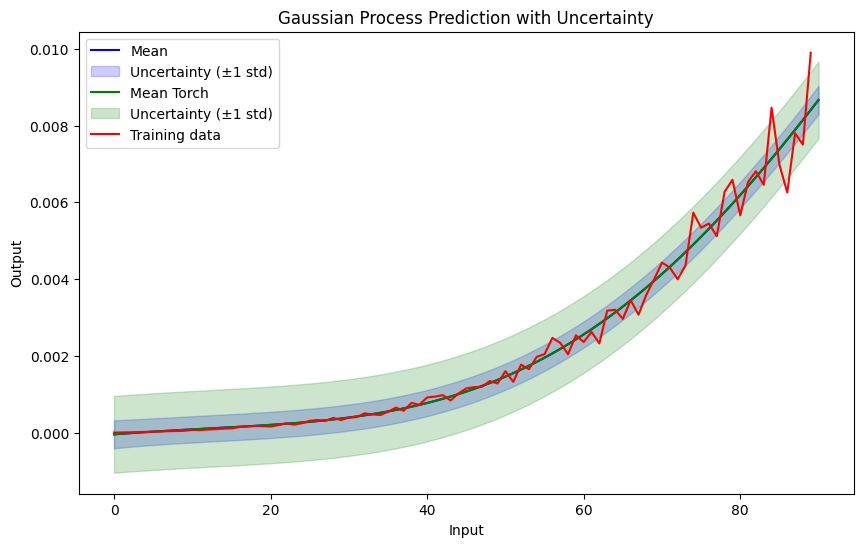

In [136]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(time_domain_training, y_mean, 'b-', label='Mean')
plt.fill_between(time_domain_training, y_mean - y_std, y_mean + y_std, color='blue', alpha=0.2, label='Uncertainty (±1 std)')
plt.plot(time_domain_training, mean_ly, 'g-', label='Mean Torch')
plt.fill_between(time_domain_training, mean_ly - std_ly, mean_ly + std_ly, color='green', alpha=.2, label='Uncertainty (±1 std)')
plt.plot(snapshots_sampled[4], 'r-', label='Training data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Gaussian Process Prediction with Uncertainty')
plt.legend()
plt.show()

### Notes

- Increase training iter, probably around ~1000
- Use the noise bounds in the guassian likelihood
- Calculate predictions from Multivariate output